# Lewinson Chapter 1 - Financial Data and Preprocessing

## Introduction

Chapter 1 of Eryk Lewinson's [*Python for Finance Cookbook*](https://www.packtpub.com/product/python-for-finance-cookbook/9781789618518) presents five stylized facts of assets returns, among other things.

We will focus on:

1. Understanding the five stylized facts of assets returns
1. More importantly, combining the skills we learned from McKinney

***Note:*** Indented block quotes are from Lewinson, and section numbers differ from Lewinson because we will not discuss every topic.

I will simplify and streamline his code, where possible.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 150
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import scipy.stats as scs
import yfinance as yf
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')

## Investigating stylized facts of asset returns

We will explore Lewinson's five stylized facts of asset returns---based on [Rama Cont (2001)](https://www.tandfonline.com/doi/abs/10.1080/713665670)---with S&P 500 exchange-traded fund (SPY) daily returns from Yahoo! Finance.
We will:

1. use the `yfinance` library to download these data, although other libraries can download these data
1. use the `requests_cache` library to cache our Yahoo! Finance request so that we do not repeatedly call the Yahoo Finance advanced programming interface (API)

Note, you may need to install yfinance and request-cache, again.

In [4]:
# %pip install yfinance requests-cache

In [5]:
spy = yf.download(tickers='SPY', session=session)

[*********************100%***********************]  1 of 1 completed

In [6]:
spy['Return'] = spy['Adj Close'].pct_change()

### Stock returns are *not* normally distributed

Daily stock returns are not normally distributed (i.e., are non-Gaussian).
Daily stock returns have:

1. negative skewness (large negative returns occur more often than large positive ones)
1. excess kurtosis (large magnitude returns, positive or negative, occur more often than if returns were normally distributed)

We can show the non-normality of daily stock returns in at least two ways:

1. descriptive statistics (also known as summary statistics)
1. histograms

We will use log returns to explore this first stylized fact only.
Simple returns cannot be less than -100%, so simple returns cannot be normally distributed.
However, log returns can approach positive and negative infinity.
Note that `np.log1p(X)` is equivalent to `np.log(1 + X)`.

In [7]:
spy['log Return'] = spy['Return'].pipe(np.log1p)

#### Summary statistics

The `.describe()` method reports mean and standard deviation (the first and second moments of the distribution) but does not report skewness and kurtosis (the third and fourth moments).
However, we can use the `.skew()` and `.kurt()` methods.

In [8]:
spy.filter(regex='Return').describe().T

,count,mean,std,min,25%,50%,75%,max
Return,7479.0000,0.0004,0.0119,-0.1094,-0.0044,0.0007,0.0059,0.1452
log Return,7479.0000,0.0004,0.0119,-0.1159,-0.0045,0.0007,0.0059,0.1356


In [9]:
print('Skewness:        {:.2f}'.format(spy['log Return'].skew()))
print('Excess Kurtosis: {:.2f}'.format(spy['log Return'].kurt()))

Skewness:        -0.31
Excess Kurtosis: 11.10


Both values are zero for the normal distribution.
Kurtosis is three for the normal distribution.
However, the `.kurt()` method reports *excess* kurtosis, which is kurtosis minus three.

#### Histograms and density plots

Histograms provide another way to see the skewness and kurtosis of daily stock returns.
We can overlay a normal distribution with the same mean and standard deviation to highlight negative skewness and excess kurtosis.

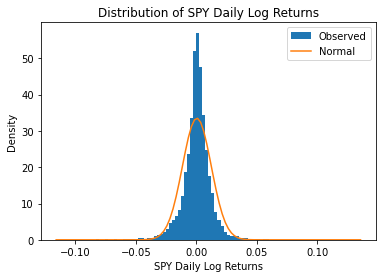

In [10]:
spy['log Return'].plot(kind='hist', bins=100, density=True, label='Observed')
xs = np.linspace(spy['log Return'].min(), spy['log Return'].max(), 100)
ys = scs.norm.pdf(x=xs, loc=spy['log Return'].mean(), scale=spy['log Return'].std())
plt.plot(xs, ys, label='Normal')
plt.title('Distribution of SPY Daily Log Returns')
plt.xlabel('SPY Daily Log Returns')
plt.ylabel('Density')
plt.legend()
# plt.semilogy()
plt.show()

If we zoom in, we can see that returns in the left tail (large magnitude negative returns) are much more likely than if they were normally distributed.
Now is an excellent opportunity to write that automates the plot above plus accepts x and y limits.

### Stock return volatility clusters in time

Stock return volatility varies across time, with alternating periods of low and high volatility.
We can visualize volatility clustering by plotting the time series of returns and volatility.
To reduce noise, we can plot the monthly means and standard deviations of daily returns.
We will learn more about the `.resample()` method in chapter 11 of McKinney.

In [11]:
spy_m = (
    spy
    .resample(rule='M', kind='period')
    ['Return']
    .agg(['mean', 'std', 'count'])
    .query('count >= 15')
    .drop(columns=['count'])
    .mul(100)
)

In the top panel, we see that there are alternating periods of low magnitude and high magnitude mean daily returns.
In the bottom panel, we see that there are alternating periods of low and high volatility.

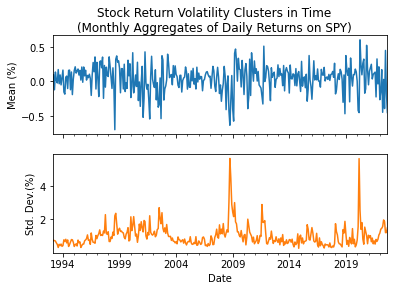

In [12]:
axes = spy_m.plot(subplots=True, legend=False)
axes[0].set_ylabel('Mean (%)')
axes[1].set_ylabel('Std. Dev.(%)')
plt.suptitle(
    'Stock Return Volatility Clusters in Time\n' + 
    '(Monthly Aggregates of Daily Returns on SPY)'
)
plt.show()

### Stock returns are *not* autocorrelated

***Stock returns today do not predict stock returns tomorrow.***
Stock returns are *not* autocorrelated, and stock returns on one day are not correlated with stock returns on previous days.
Therefore, we cannot predict future returns with past returns.
Serial correlation is a synonym for autocorrelation.
We can show this with an autocorrelation plot of daily stock returns.
The height of each line indicates the correlation coefficient ($\rho$) between returns on day 0 and lag $t$ (i.e., day $0 - t$).

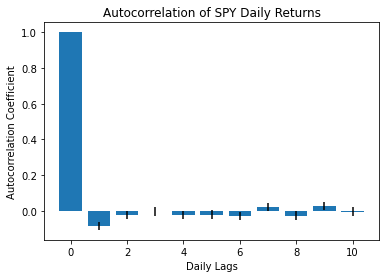

In [13]:
N = 10
spy_lags = pd.concat(objs=[spy['Return'].shift(t) for t in range(N + 1)], axis=1)
corrs = spy_lags.corr().iloc[0]
serrs = np.sqrt((1 - corrs**2) / (spy_lags.count() - 2))

plt.bar(height=corrs, x=range(N + 1), yerr=2*serrs)
plt.title('Autocorrelation of SPY Daily Returns')
plt.xlabel('Daily Lags')
plt.ylabel('Autocorrelation Coefficient')
plt.show()

The plot above suggests weak, negative autocorrelation ($\rho \approx -0.09$) for the 1-day lag.
However, this is due to bid-ask bounce.
About half the time, positive returns follow negative returns (and *vice versa*) if closing prices randomly alternate between the bid and ask without changes in true prices.
If we repeat the autocorrelation plot above monthly data, the negative autocorrelation disappears.

### *Squared* stock returns *are* autocorrelated with slowly decaying autocorrelation

Because volatility clusters in time, squared stock returns (and the absolute values of stock returns) are autocorrelated.

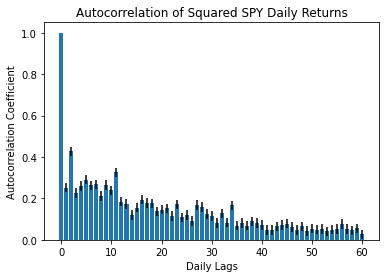

In [14]:
N = 60
spy_lags = pd.concat(objs=[spy['Return'].shift(t) for t in range(N + 1)], axis=1)
corrs = (spy_lags ** 2).corr().iloc[0]
serrs = np.sqrt((1 - corrs**2) / (spy_lags.count() - 2))

plt.bar(height=corrs, x=range(N + 1), yerr=2*serrs)
plt.title('Autocorrelation of Squared SPY Daily Returns')
plt.xlabel('Daily Lags')
plt.ylabel('Autocorrelation Coefficient')
plt.show()

### The leverage effect - volatility and returns are negatively correlated

> One of the most enduring empirical regularities in equity markets is the inverse relationship between stock prices and volatility, first documented by Black (1976) who attributed it to the effects of financial leverage. As a company's stock price declines, it becomes more highly leveraged given a fixed level of debt outstanding, and this increase in leverage induces a higher equity-return volatility... [(Hasanhodzic and Lo, 2011)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1762363)

We can visualize the leverage effect by plotting the monthly mean and standard deviation of daily returns.
We typically want to report *annualized* mean and volatility of returns (i.e., multiply the mean and volatility of daily returns by 252 and $\sqrt{252}$).
However, we will plot daily values here  because some annualized values would be very large when we estimate means and volatilities using only one month of data.

In [15]:
spy_m = (
    spy
    .resample(rule='M', kind='period')
    ['Return']
    .agg(['mean', 'std', 'count'])
    .query('count >= 15')
    .drop(columns=['count'])
    .mul(100)
    .assign(mean_lag1 = lambda x: x['mean'].shift(1))
)

/home/richard/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


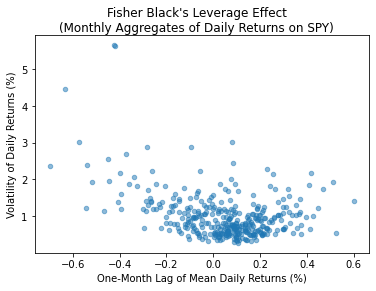

In [16]:
spy_m.plot(x='mean_lag1', y='std', kind='scatter', alpha=0.5)
plt.xlabel('One-Month Lag of Mean Daily Returns (%)')
plt.ylabel('Volatility of Daily Returns (%)')
plt.suptitle(
    'Fisher Black\'s Leverage Effect\n' + 
    '(Monthly Aggregates of Daily Returns on SPY)'
)
plt.show()

## Conclusion

Financial data analysts should know that real data do not exactly behave as we learn in finance 101.

1. Stock returns are non-Gaussian (not normally distributed) with:
    a. Negative skew
    a. Excess kurtosis
1. stock return volatility clusters in time
1. stock returns are *not* autocorrelated
1. *however,* squared stock returns *are* autocorrelated
1. stock volatility and stock returns are inversely related

## Practice

***Practice:***
Repeat the autocorrelation plot above with *monthly* returns instead of *daily* returns.

***Practice:*** 
Plot monthly returns versus their one-month lag.
That is, plot $Return_{t=0}$ against $Return_{t=-1}$.

***Practice:***
Repeat the autocorrelation plot with the *absolute value* of daily returns instead of *squared* daily returns.